# 03 — Hedging Experiment
In this notebook, we compute delta for Kou's call option. We implement delta hedgings, local risk-minimizing hedgings, and two-asset hedgings, and compare their performances on portfolio profits.


Let $T$ be the expiration time and $k = \ln K$ the logarithmic of the strike price. The delta of the call option under Kou's jump diffusion model is given 

$$
\Delta(C_T(k)) = \dfrac{\partial}{\partial S_0} C_T(k) = L_\xi^{-1}(e^{-rT} \dfrac{S_0^\xi}{\xi}\exp(G(\xi+1)T)) \\
= \frac{1}{2\pi i}\int_{c-i\infty}^{c+i\infty} \dfrac{e^{-rT}}{\xi}e^{G(\xi+1)T}(\dfrac{S_0}{K})^\xi\mathrm{d}\xi \\
= e^{-rT}(\dfrac{S_0}{K})^c\dfrac{1}{\pi} \int_{0}^{\infty} \Re\!\big( \dfrac{e^{G(c+iu+1)T} (S_0/K)^{iu}}{c+iu})\mathrm{d}u.
$$

where $L_\xi^{-1}$ is the Laplace inversion with respect to $\xi$, $G$ is the cumulant exponent of $\ln{S_t/S_0}$, under risk-neutral condition is given by

$$
G(\theta)=\theta\!\left(r-\lambda\zeta-\tfrac12\sigma^2\right)  + \tfrac12\sigma^2\theta^2  + \lambda\!\left( p\frac{\eta_1}{\eta_1-\theta} + (1-p)\frac{\eta_2}{\eta_2+\theta} - 1 \right).
$$ 

In [7]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

# For reproducibility
def rng(seed=None):
    return np.random.default_rng(seed)

In [ ]:
def double_exponential_jump_sums(nums_jumps, p, eta1, eta2, rg):
    """
    return total jump sizes sum of Y_i's during a small time interval dt
    nums_jumps: array of numbers of jumps occuring during dt for different stock paths
    size of each jump Y_i is double exponential, namely +Exp(eta1) with probability p, 
    or -Exp(eta2) with probability 1-p.
    
    Vectorized implementation using a Binomial split and Gamma sums.

    total_Y = Sum_{j=1..nums_jumps} Y_j 
          = Gamma(nums_up_jumps, scale=1/eta1) /
            - Gamma(nums_down_jumps, scale=1/eta2).

    """
    nums_jumps = np.asarray(nums_jumps, dtype=np.int64)
    if nums_jumps.ndim == 0:
        nums_jumps = nums_jumps[None]
    
    # Divide all jumps into upward and downward jumps by binomial random draws
    nums_up_jumps = rg.binomial(nums_jumps, p)
    nums_down_jumps = nums_jumps - nums_up_jumps
    
    # Gamma(shape=nums_jumps, scale=1/eta). For k=0, we want 0, which means no jump. Handle zeros safely.
    total_Y_up = np.zeros_like(nums_jumps, dtype=float)
    up_jumps_indices = nums_up_jumps > 0 
    if up_jumps_indices.any():
        total_Y_up[up_jumps_indices] = rg.gamma(shape=nums_up_jumps[up_jumps_indices], scale=1.0/eta1)
    
    total_Y_down = np.zeros_like(nums_jumps, dtype=float)
    down_jumps_indices = nums_down_jumps > 0
    if down_jumps_indices.any():
        total_Y_down[down_jumps_indices] = rg.gamma(shape=nums_down_jumps[down_jumps_indices], scale=1.0/eta2)
    
    total_Y = total_Y_up - total_Y_down
    return total_Y.reshape(nums_jumps.shape)


def kou_stock_paths(
    S0: float,
    T: float,
    steps: int,
    nstock_paths: int,
    sigma: float,
    lam: float,
    p: float,
    eta1: float,
    eta2: float,
    mu: float = None,
    r: float = None,
    seed: int = 42,
):
    """
    Simulate paths for Kou's double-exponential jump-diffusion.
    
    Inputs:
        S0: underlying stock price at time 0
        T: time to expiration in years
        steps: time steps
        nstock_paths: number of simulated paths
        sigma: yearly volatility
        lam: yearly jump intensity
        p: probability of up-jump (Y ~ +Exp(eta1)); q = 1 - p (down-jump Y ~ -Exp(eta2))
        eta1: rate of upward exponential; must satisfy eta1 > 1 for finite E[V]
        eta2: rate of downward exponential (> 0)
        mu: physical drift (use if r is None)
        r: risk-free interest rate; if provided, simulator uses risk-neutral drift (preferred for pricing)
        seed: RNG seed
    
    Returns:
        times (shape steps+1,), paths array (shape steps+1, nstock_paths)
    """
    assert S0 > 0 and T > 0 and steps >= 1 and nstock_paths >= 1
    assert sigma >= 0 and lam >= 0
    assert 0.0 <= p <= 1.0 and eta1 > 0 and eta2 > 0
    
    dt = T / steps
    rg = rng(seed)
    
    # Drift term in log S increment:
    if r is not None:
        # Risk-neutral drift uses zeta = E[e^Y]-1
        zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0
        mu_tilde = (r - 0.5 * sigma**2 - lam * zeta)
    else:
        if mu is None:
            raise ValueError("Provide either mu (physical) or r (risk-neutral).")
        mu_tilde = (mu - 0.5 * sigma**2)
    
    # Pre-allocate
    paths = np.empty((steps + 1, nstock_paths), dtype=float)
    paths[0, :] = S0
    sqrt_dt = np.sqrt(dt)
    
    # Draw Brownian increments and Poisson jump counts
    dW = rg.normal(loc=0.0, scale=sqrt_dt, size=(steps, nstock_paths))
    J = rg.poisson(lam=lam * dt, size=(steps, nstock_paths))
    
    # For each time step, compute jump-sum and log increment
    for t in range(steps):
        Y_sum = double_exponential_jump_sums(J[t], p=p, eta1=eta1, eta2=eta2, rg=rg)
        dX = mu_tilde * dt + sigma * dW[t] + Y_sum
        paths[t + 1] = paths[t] * np.exp(dX)
    
    times = np.linspace(0.0, T, steps + 1)
    return times, paths


def kou_cumulant(theta, r, sigma, lam, p, eta1, eta2):
    """
    Kou cumulant G(theta) for the log-return process X_T = ln S_T - ln S_0 under Q.

    Definition:
        G(theta) = theta * (r - lambda*zeta - 0.5*sigma^2) + 0.5*sigma^2 * theta^2
                   + lambda * ( p * eta1 / (eta1 - theta) + (1-p) * eta2 / (eta2 + theta) - 1 )

    where zeta = E[e^Y - 1] for Y ~ double-exponential jumps:
        zeta = p * eta1/(eta1 - 1) + (1-p) * eta2/(eta2 + 1) - 1

    Parameters
    ----------
    theta : float or complex or array-like
        Laplace variable. Valid for Re(theta) in (-eta2, eta1).
        Can be a numpy array of complex numbers (e.g., theta = c+1j*u + 1).
    r : float
        Risk-free rate (continuous compounding).
    sigma : float
        Diffusion volatility (>= 0).
    lam : float
        Jump intensity lambda (>= 0).
    p : float
        Probability of an upward jump (in (0,1)).
    eta1 : float
        Rate of upward exponential jump sizes (+Exp(eta1)); must satisfy eta1 > 1 for finiteness of E[e^Y].
    eta2 : float
        Rate of downward exponential jump sizes (-Exp(eta2)); must satisfy eta2 > 0.

    Returns
    -------
    G : complex ndarray or complex
        Same shape as theta. Complex-valued in general.
    """
    
    theta = np.asarray(theta, dtype=np.complex128)

    # Risk-neutral compensator for jumps
    zeta = p * (eta1 / (eta1 - 1.0)) + (1.0 - p) * (eta2 / (eta2 + 1.0)) - 1.0

    drift_term = theta * (r - lam * zeta - 0.5 * sigma**2)
    diff_term  = 0.5 * (sigma**2) * (theta**2)
    jump_term  = lam * ( p * (eta1 / (eta1 - theta)) + (1.0 - p) * (eta2 / (eta2 + theta)) - 1.0 )

    return drift_term + diff_term + jump_term


def kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2):
    """
    Bilateral Laplace transform of the call price C_T(k) w.r.t. k = -ln K.

        Chat(xi) = ∫_{-∞}^{∞} e^{-xi k} C_T(k) dk
                 = e^{-rT} * S0^{xi+1} / [ xi (xi+1) ] * exp( G(xi+1) * T )

    where G is the Kou cumulant from `kou_cumulant`.

    Parameters
    ----------
    xi : float/complex or array-like
        Laplace variable for k. Must satisfy Re(xi) > 0 and Re(xi+1) in (-eta2, eta1).
    S0 : float
        Spot price (S0 > 0).
    T : float
        Time to maturity in years (T >= 0).
    r, sigma, lam, p, eta1, eta2 : floats
        Kou model parameters under the risk-neutral measure.

    Returns
    -------
    Chat : complex ndarray or complex
        Transform values at xi; same shape as xi.
    """

    xi = np.asarray(xi, dtype=np.complex128)
    theta = xi+1
    G = kou_cumulant(theta, r, sigma, lam, p, eta1, eta2)
    # compute S0^(xi+1) robustly for complex xi
    return np.exp(-r*T) * (S0**(xi+1)) * np.exp(G*T) / (xi * (xi + 1))


def kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2,
                           c=None, u_max=200.0, N=4000):
    if c is None:
        c = 0.5 * min(eta1 - 1.0, 1.0)
        c = max(c, 1e-3)
    k = -np.log(K)
    u = np.linspace(1e-6, u_max, N)
    xi = c + 1j*u
    Chat = kou_call_laplace_transform(xi, S0, T, r, sigma, lam, p, eta1, eta2)
    integrand = np.real(np.exp(1j*u*k) * Chat)
    du = (u_max - u[0]) / (N - 1)
    val = np.exp(c*k)/np.pi * np.trapezoid(integrand, dx=du)
    return float(max(val, 0.0))


In [136]:
def kou_call_delta(S0, K, T,r, sigma, lam, p, eta1, eta2, c= None, u_max = 200, N = 4000):
    '''
    Kou Delta for Call Option

    Inputs: 
    S0: underlying stock price at time 0
    T: time to expiration in years
    
    sigma: yearly volatility
    lam: yearly jump intensity
    p: probability of up-jump (Y ~ +Exp(eta1)); q = 1 - p (down-jump Y ~ -Exp(eta2))
    eta1: rate of upward exponential; must satisfy eta1 > 1 for finite E[V]
    eta2: rate of downward exponential (> 0)
    r: risk-free interest rate

    Return:
    Kou rate of change of call option with respect to S_0
    
    '''

    if T <= 0:
        return 1.0 if S0 > K else 0.0
    if c is None:
        c = min(0.5, max(1e-3, 0.25*(eta1 - 1)))  # choose 0 < c < eta1 - 1

    u = np.linspace(0.0, u_max, int(N) + 1)
    du = u[1] - u[0]
    xi = c + 1j*u
    theta = xi + 1.0
    phase = np.exp(1j * u * np.log(S0 / K))

    G = kou_cumulant(theta, r, sigma, lam, p, eta1, eta2)  # per-unit-time
    integrand = np.exp(G * T) * phase / xi
    re = integrand.real
    integral = du * (0.5 * re[0] + re[1:-1].sum() + 0.5 * re[-1])

    return float(math.exp(-r * T) * (S0 / K) ** c * (integral / math.pi))

def bs_call_delta(S0, K, sigma, T, r):
    '''Black-Scholes Delta of Call Option
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    T: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes rate of change of call option with respect to S_0
    
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*T)/(sigma*np.sqrt(T))
    
    
    return norm.cdf(d1)


In [149]:
#Sample for computing Kou delta and comparison between results obtained by Kou and Black-Scholes

r, sigma = 0.02, 0.20
lam, p, eta1, eta2 = 0.7, 0.3, 25.0, 10.0  # moderate jump activity
T_list  = [0.25, 1.00]
S0_list = [90.0, 100.0, 110.0]
K_list  = [90.0, 100.0, 110.0]

# --- Build the table ---
rows = []
for T in T_list:
    for S0 in S0_list:
        for K in K_list:
            d_kou = kou_call_delta(S0, K, T, r, sigma, lam, p, eta1, eta2,
                                           c=0.4, u_max=200, N=20000)
            d_bs  = bs_call_delta(S0, K, sigma, T, r)
            rows.append(dict(T=T, S0=S0, K=K, KouDelta=d_kou, BSDelta=d_bs, DeltaDifference = d_kou - d_bs))

df = pd.DataFrame(rows)[["T","S0","K","KouDelta","BSDelta", "DeltaDifference"]]
display(df.round(6))  

,T,S0,K,KouDelta,BSDelta,DeltaDifference
0,0.25,90.0,90.0,0.553073,0.539828,0.013246
1,0.25,90.0,100.0,0.188402,0.170142,0.018260
2,0.25,90.0,110.0,0.035344,0.028279,0.007065
3,0.25,100.0,90.0,0.867111,0.875669,-0.008558
4,0.25,100.0,100.0,0.553073,0.539828,0.013246
5,0.25,100.0,110.0,0.215863,0.196801,0.019061
6,0.25,110.0,90.0,0.970465,0.982429,-0.011964
7,0.25,110.0,100.0,0.846817,0.853853,-0.007036
8,0.25,110.0,110.0,0.553073,0.539828,0.013246
9,1.00,90.0,90.0,0.590586,0.579260,0.011326


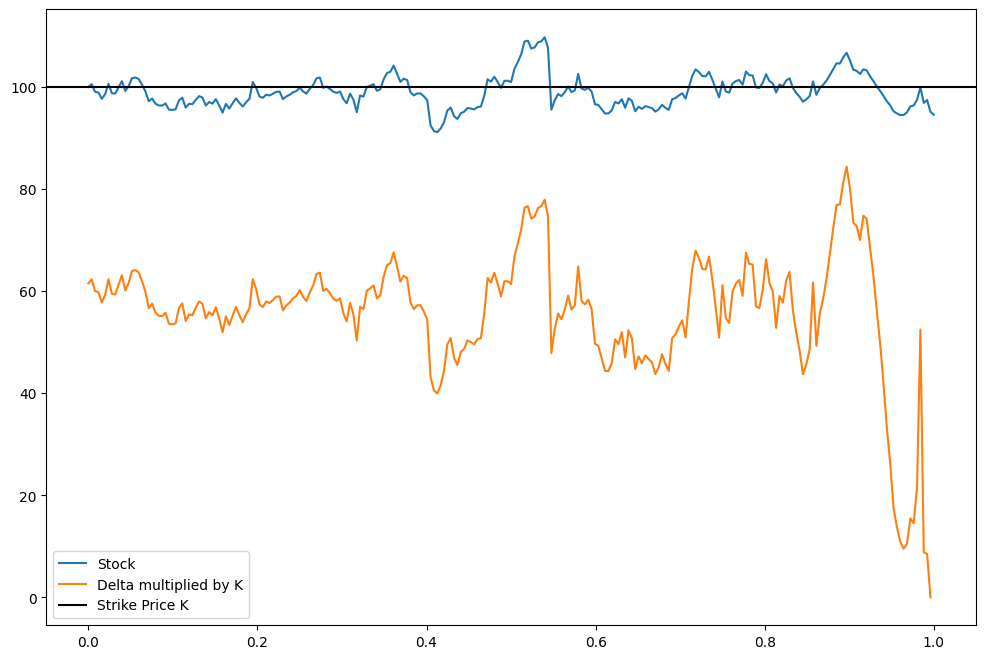

In [39]:
#Simulate Stock Path and create visual of deltas through expiration.

# Parameters
S0    = 100.0
T     = 1.0
steps = 252
paths = 1
K =100
sigma = 0.2
lam   = 3.0       # avg 3 jumps per year
p     = 0.3       # 30% upward jumps
eta1  = 25.0      # avg up-jump size ~ 1/eta1 = 4% (in log)
eta2  = 12.5      # avg down-jump magnitude ~ 1/eta2 = 8%
r     = 0.03

times, S_Kou = kou_stock_paths(S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=None)

stock_path = S_Kou[:,0]

# build per-step inputs (length = steps)
spots = stock_path[:steps]
taus  = (T - times)[:steps]

# compute Kou delta at each step (scalar calls)
deltas = np.array([
    kou_call_delta(S, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=200, N=20000)
    for S, tau in zip(spots, taus)
])



plt.figure(figsize = (12,8))

plt.plot(times, stock_path, label = 'Stock')

plt.plot(times[:steps], K*deltas, label = 'Delta multiplied by K')


plt.axhline(K, label = 'Strike Price K', color = 'black')


plt.legend()
plt.show()

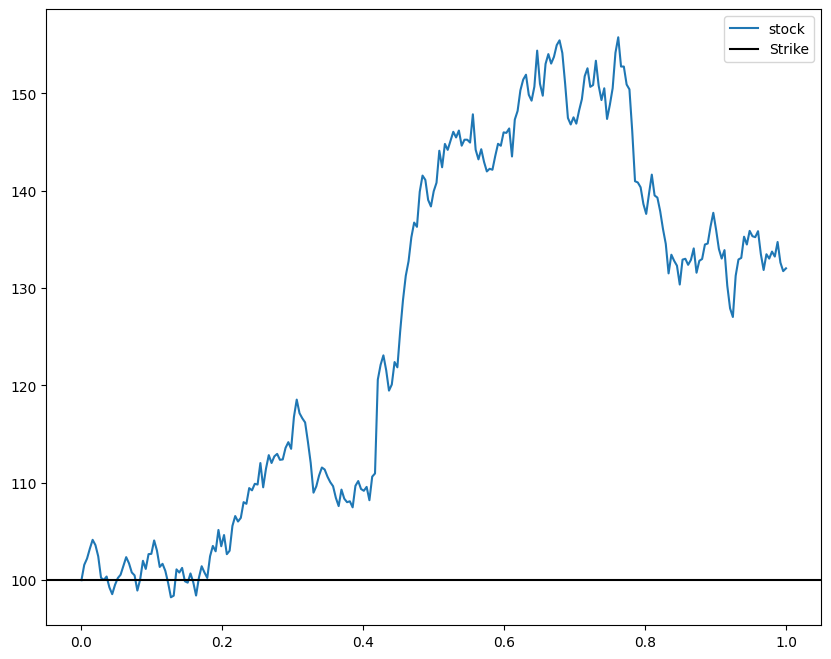

Kou expected profit: $157.81
----------------------------------------------------------------------------------------------------
Simulated Profit $248.18


In [40]:
#Simulate stock path, and then explore the effect of Delta-hedging from the point of view of 
# a market maker selling an option contract on the market.



# Parameters
S0    = 100.0
T     = 1.0
steps = 252
paths = 1
K =100
sigma = 0.2
lam   = 3.0       # avg 3 jumps per year
p     = 0.3       # 30% upward jumps
eta1  = 25.0      # avg up-jump size ~ 1/eta1 = 4% (in log)
eta2  = 12.5      # avg down-jump magnitude ~ 1/eta2 = 8%
r     = 0.03

times, S_Kou = kou_stock_paths(S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=None)

stock_path = S_Kou[:,0]


spots = stock_path[:steps]
taus  = (T - times)[:steps]

deltas = np.array([
    kou_call_delta(S, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=200, N=20000)
    for S, tau in zip(spots, taus)
])



premium = kou_call_laplace_price(S0, K, T, r, sigma+0.05, lam, p, eta1, eta2, c=None, u_max= 200, N = 20000)


n_options = 100



dt = T/steps



call_payout_discounted = np.maximum(stock_path[-1]-K, 0)*np.exp(-r*T)



stock_profits_discounted = (stock_path[1:steps +1] - \
                            stock_path[0:steps]*np.exp(r*dt))*np.exp(-r*times[1:steps+1])*deltas


total_stock_profit_discounted = np.sum(stock_profits_discounted)



portfolio_pl = n_options*(premium - call_payout_discounted + total_stock_profit_discounted)


Kou_predicted_profit = n_options*(premium- kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2, c=None, u_max= 200, N = 20000))


plt.figure(figsize = (10,8))


plt.plot(times, stock_path, label = 'stock')

plt.axhline(K, label='Strike', color = 'black')


plt.legend()
plt.show()

print(f'Kou expected profit: ${Kou_predicted_profit:.2f}')

print('-'*100)

print(f'Simulated Profit ${portfolio_pl:.2f}')

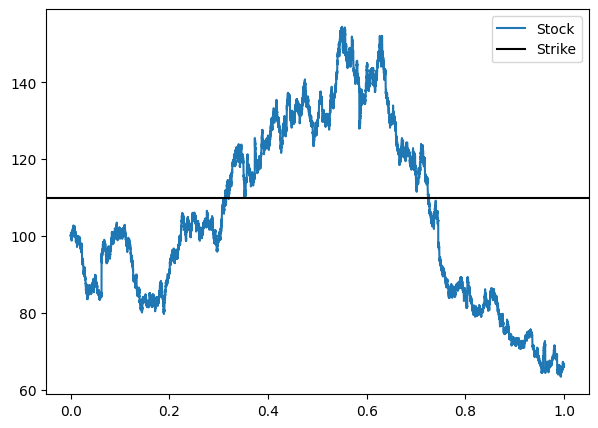

Simulated Portfolio profit 25200 delta hedges: $3.10
Portfolio profit no hedging: $18.67
Expected Profit: $1.67


In [159]:
#We will illustrate that unlike Black-Scholes, jump-diffusion model does not have perfect hedgings (incomplete market)


# Parameters
S0    = 100.0
T     = 1.0
steps = 252*100
paths = 1
K = 110
sigma = 0.41
lam   = 12      # avg 12 jumps per year
p     = 0.3       # 30% upward jumps
eta1  = 12.5      # avg up-jump size ~ 1/eta1 (in log)
eta2  = 25.0      # avg down-jump magnitude ~ 1/eta2 
r     = 0.03

times, S_Kou = kou_stock_paths(S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=None)

stock_path = S_Kou[:,0]

# build per-step inputs (length = steps)
spots = stock_path[:steps]
taus  = (T - times)[:steps]

# compute Kou delta at each step (scalar calls)
deltas = np.array([
    kou_call_delta(S, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=200, N=4000)
    for S, tau in zip(spots, taus)
])

premium = kou_call_laplace_price(S0, K, T, r, sigma+0.05, lam, p, eta1, eta2, c=None, u_max= 200, N = 4000)



dt = T/steps



call_payout_discounted = np.maximum(stock_path[-1]-K, 0)*np.exp(-r*T)


stock_profits_discounted = (stock_path[1:steps +1] - \
                            stock_path[0:steps]*np.exp(r*dt))*np.exp(-r*times[1:steps+1])*deltas


total_stock_profit_discounted = np.sum(stock_profits_discounted)



profit_of_call_with_hedging = call_payout_discounted - total_stock_profit_discounted
hedged_portfolio_selling_call = premium - profit_of_call_with_hedging


expected_portfolio_profit = premium- kou_call_laplace_price(S0, K, T, r, sigma, lam, p, eta1, eta2, c=None, u_max= 200, N = 4000)

plt.figure(figsize = (7,5))

plt.plot(times, stock_path, label = 'Stock')

plt.axhline(K, label = 'Strike', color = 'black')

plt.legend()

plt.show()


print(f'Simulated Portfolio profit {steps} delta hedges: ${hedged_portfolio_selling_call:.2f}')

print(f'Portfolio profit no hedging: ${premium - call_payout_discounted:.2f}')

print(f'Expected Profit: ${expected_portfolio_profit:.2f}')


#Explaination for discrepancy even in large amount of hedgings: delta hedge cancels the diffusive part,
#but when a jump hits, price moves discontinuously and one cannot rebalance at the pre-jump delta.

## Local Risk-Minimizing (LRM) Hedging Strategy
Consider an agent who has sold at $t=0$ the contingent claim with terminal payoff $Y$ for the price $c$ and want to hedge the associated
risk by trading in assets $(X^1, \cdots, X^m)= X$. We call an admissible hedging strategy a pridictable process $\phi:\Omega \times [0,T] \to \mathbb{R}^m$
 such that $\int^T_0 \phi_t dX_t$ is a square integrable martingale. The residual hedging error of one such strategy $\phi$ at time $T$
 is then given by 

 $$
 \epsilon_T(c,\phi) = c - Y - \int^T_0 \phi_t dX_t
 $$

The minimal variance hedging is to find $\phi$ which minimizes $\mathbb{E}[\epsilon_T(c,\phi)^2]$. In the case of selling European call option,
and the asset is one stock $X = X^1$, under Black-Scholes we have a perfect hedging. That is, $c = e^{-rT}\mathbb{E}[\max\{S_T-K,0\}]$,
$Y = e^{-rT}\max\{S_T-K,0\}$, we take $\phi_t$ to be the delta $\Delta_t$ of the stock price at time t, so that $\epsilon_T = 0$.

In the case of jump diffusion model, the market is incomplete, pure delta hedging does not minimize the risk as
it does not incorporate with jumps of price. What we gonna do is to minimize the variance locally using $L_2$ orthogonal projection.


**Setup:**

- Stock increment under Kou's model (risk-neutral and drift omitted):  
  $\Delta S_t = \sigma S_t \Delta W_t + S_t (e^{Y}-1)\Delta N_t$,  
  where $\Delta N_t\in\{0,1\}$ with intensity $\lambda$ and $Y$ (Kou double-exponential).
- Option value $F(t,S_t)$, its delta $F_s(t,S_t)$.

**LRM objective:**  Find the Hedge ratio by local $L_2$-projection 
$$\displaystyle
\phi_t = \arg\min_\varphi \mathbb{E}[(\Delta F_t - \varphi\,\Delta S_t)^2 \mid \mathcal F_t]
= \frac{\mathrm{Cov}_t(\Delta F_t, \Delta S_t)}{\mathrm{Var}_t(\Delta S_t)}.$$

Condition on a jump now with size $Y$. Let $s=S_{t-}$, define stock price increment of jump part $\Delta S^{(j)} = s(e^{Y}-1)$, similarly, option value incremen contributed by the jump $\Delta F^{(j)} = F(t,se^{Y})-F(t,s)$, and let $E_Y[\cdot]$ denote expectation over the **jump size distribution** of $Y$ conditional on a jump.
Let $\sigma^2_{\text{diff}}=\sigma^2$, $\sigma^2_{\text{jump}}=\lambda E[(e^{Y}-1)^2]$, and $\gamma=\sigma^2_{\text{jump}}/(\sigma^2_{\text{diff}}+\sigma^2_{\text{jump}})$.
Then by Barbara Grnewald and Siegfried Trautmannhe (cite here, lemma 2) the desired hedge ratio is given by

$$
\boxed{\;\phi_t = (1-\gamma)\,F_s(t,s) \, + \, \gamma\,\frac{E_Y(\Delta S^{(j)}\,\Delta F^{(j)})}{E_Y(\Delta (S^{(j)})^2)}\;}
$$
with
$\dfrac{E_Y(\Delta S^{(j)}\,\Delta F^{(j)})}{E_Y(\Delta (S^{(j)})^2)}\;
 = \dfrac{E[(F(t,se^{Y})-F(t,s))(e^{Y}-1)]}{s\,E[(e^{Y}-1)^2]}$.

 Intuitively, 

 **No jump step:** hedge acts like delta via $(1-\gamma)F_s$.  **Jump step:** hedge uses the jump‑regression slope with weight $\gamma$.  

After plugging the value of $\gamma$, we get 

$$
\boxed{\;\phi_{\text{LRM}}(t,s) \coloneqq \phi_t = 
F_s(t,s) +
\frac{\lambda\,E\!\left[(F(t,se^{Y})-F(t,s)-s(e^{Y}-1)F_s(t,s))(e^{Y}-1)\right]}
{s\left(\sigma^2+\lambda\,E[(e^{Y}-1)^2]\right)}\;}
$$

Recall: $E[e^{kY}] = p\,\eta_1/(\eta_1-k) + (1-p)\,\eta_2/(\eta_2+k)$;  $E[(e^{Y}-1)^2] = E[e^{2Y}] - 2E[e^{Y}] + 1$.


In [156]:
#Let's design function for LRM hedging.

from numpy.polynomial.laguerre import laggauss

def E_exp_kY(k, p, eta1, eta2):
    # E[e^{kY}] for Kou jumps
    return p * (eta1 / (eta1 - k)) + (1.0 - p) * (eta2 / (eta2 + k))

def E_eY_minus1_sq(p, eta1, eta2):
    Ey  = E_exp_kY(1.0, p, eta1, eta2)
    E2y = E_exp_kY(2.0, p, eta1, eta2)
    return E2y - 2.0*Ey + 1.0

def _kou_expectation(fun_y, p, eta1, eta2, n=16):
    # Split-domain Gauss–Laguerre quadrature:
    # y >= 0 branch: density eta1 * exp(-eta1 y)
    # y < 0 branch: change var u=-y >= 0 with density eta2 * exp(-eta2 u)
    x, w = laggauss(n)  # ∫_0^∞ e^{-x} g(x) dx ≈ sum w_i g(x_i)
    # positive jumps (y = x/eta1)
    term_pos = np.sum(w * np.array([fun_y(+xx/eta1) for xx in x]))
    # negative jumps (y = -x/eta2)
    term_neg = np.sum(w * np.array([fun_y(-xx/eta2) for xx in x]))
    return p * term_pos + (1.0 - p) * term_neg

def phi_LRM_scalar(s, tau, K, r, sigma, lam, p, eta1, eta2,
                   price_fun, delta_fun, u_max=200, N=4000, quad_n=16):
    # F = call price under Kou (Laplace); Fs = Kou delta
    F  = price_fun(s, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=u_max, N=N)
    Fs = delta_fun(s, K, tau, r, sigma, lam, p, eta1, eta2,
                   c=None, u_max=u_max, N=N)

    def integrand(y):
        Fy = price_fun(s*np.exp(y), K, tau, r, sigma, lam, p, eta1, eta2,
                       c=None, u_max=u_max, N=N)
        return (Fy - F - s*(np.exp(y)-1.0)*Fs) * (np.exp(y)-1.0)

    jump_corr = lam * _kou_expectation(integrand, p, eta1, eta2, n=quad_n)
    denom = s * (sigma**2 + lam * E_eY_minus1_sq(p, eta1, eta2))
    return Fs + jump_corr / denom



Summary across 100 simulations


,mean,std,p05,p50,p95
Delta,3.992885,5.595025e+00,-7.776508,4.939606,10.354976
LRM,3.624702,5.526101e+00,-9.327101,3.500530,12.046011
No hedge,15.316126,5.302633e+01,-94.226908,40.846518,40.846518
Expected Profit,3.296686,4.463264e-16,3.296686,3.296686,3.296686


Share LRM profit > Delta profit: 39.00%


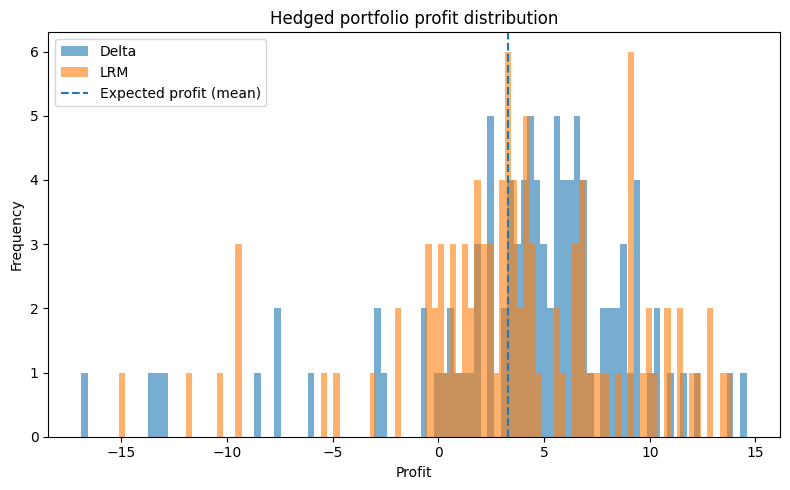

In [178]:
# --- small wrapper to call kou_stock_paths with positional arguments ---
from IPython.display import display

def _simulate_kou_path(S0, T, steps, sigma, lam, p, eta1, eta2, r, seed):
    """
    Tries common kou_stock_paths signatures:
      (S0, T, steps, paths, sigma, lam, p, eta1, eta2, r=r, seed=seed)
      (S0, T, steps, paths, sigma, lam, p, eta1, eta2, r,    seed)
    """
    # preferred: positional 'paths=1' + keyword r/seed
    try:
        return kou_stock_paths(S0, T, steps, 1, sigma, lam, p, eta1, eta2, r=r, seed=seed)
    except TypeError:
        # fallback: everything positional
        return kou_stock_paths(S0, T, steps, 1, sigma, lam, p, eta1, eta2, r, seed)

# Test (Demo): We simulate stock paths and compare hedged portfolio profits under delta and LRM, moreover we compare them with the expected profit
# obtained by the 'closed' formula of Kou's model (Laplace transform) and conclude that LRM is slightly better than delta hedging, which fits our 
# intuition as it also hedges jump parts.


def run_one_sim(S0, K, T, steps, r, sigma, lam, p, eta1, eta2,
                price_fun, delta_fun, path_seed=None,
                premium_sigma_shift=0.05, quad_n=12, N_price=4000):

    # 1) simulate one Kou path 
    times, S_Kou = _simulate_kou_path(S0, T, steps, sigma, lam, p, eta1, eta2, r, path_seed)
    stock_path = S_Kou[:, 0]
    dt = T / steps

    # 2) per-step inputs
    spots = stock_path[:steps]
    taus  = (T - times)[:steps]

    # 3) delta positions
    deltas = np.array([
        delta_fun(S, K, tau, r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
        for S, tau in zip(spots, taus)
    ])

    # 4) LRM positions
    lrm_positions = np.array([
        phi_LRM_scalar(S, tau, K, r, sigma, lam, p, eta1, eta2,
                       price_fun=price_fun, delta_fun=delta_fun,
                       u_max=200, N=N_price, quad_n=quad_n)
        for S, tau in zip(spots, taus)
    ])

    # 5) premium (using slightly higher sigma)
    premium = price_fun(S0, K, T, r, sigma + premium_sigma_shift, lam, p, eta1, eta2,
                        c=None, u_max=200, N=N_price)

    # 6) discounted payoff
    call_payout_discounted = max(stock_path[-1] - K, 0.0) * np.exp(-r*T)

    # 7) stock-only discounted gains
    gains_delta = (stock_path[1:] - stock_path[:-1] * np.exp(r*dt)) * np.exp(-r * times[1:]) * deltas
    gains_lrm   = (stock_path[1:] - stock_path[:-1] * np.exp(r*dt)) * np.exp(-r * times[1:]) * lrm_positions

    G_delta = float(gains_delta.sum())
    G_lrm   = float(gains_lrm.sum())

    # hedger profits for the short call
    profit_call_with_delta = call_payout_discounted - G_delta
    profit_call_with_lrm   = call_payout_discounted - G_lrm

    delta_profit = premium - profit_call_with_delta
    lrm_profit   = premium - profit_call_with_lrm
    nohedge_profit = premium - call_payout_discounted

    # expected profit if priced with true sigma (pricing diff only)
    expected_profit = premium - price_fun(S0, K, T, r, sigma, lam, p, eta1, eta2,
                                          c=None, u_max=200, N=N_price)

    return dict(
        delta_profit=delta_profit,
        lrm_profit=lrm_profit,
        nohedge_profit=nohedge_profit,
        expected_profit=expected_profit,
        path=stock_path, times=times,
        deltas=deltas, lrm_positions=lrm_positions
    )




# --------------------
def run_experiments(n_sims=50, base_seed=1234,
                    S0=100.0, K=110.0, T=1.0, steps=252,
                    r=0.03, sigma=0.41, lam=12.0, p=0.3, eta1=12.5, eta2=25.0,
                    premium_sigma_shift=0.05, quad_n=12, N_price=2500):
    """
    Run n_sims independent paths and compare Delta vs LRM hedging profits.
    Returns (df, fig1, fig2).
    """
    delta_list, lrm_list, nohedge_list, exp_list = [], [], [], []

    for i in range(n_sims):
        seed = None if base_seed is None else base_seed + i
        out = run_one_sim(
            S0, K, T, steps, r, sigma, lam, p, eta1, eta2,
            price_fun=kou_call_laplace_price, delta_fun=kou_call_delta,
            path_seed=seed, premium_sigma_shift=premium_sigma_shift,
            quad_n=quad_n, N_price=N_price
        )
        delta_list.append(out["delta_profit"])
        lrm_list.append(out["lrm_profit"])
        nohedge_list.append(out["nohedge_profit"])
        exp_list.append(out["expected_profit"])

    df = pd.DataFrame({
        "delta_profit": delta_list,
        "lrm_profit": lrm_list,
        "nohedge_profit": nohedge_list,
        "expected_profit": exp_list
    })

    # Summary table
    def summary(x):
        x = np.asarray(x)
        return pd.Series({
            "mean": np.mean(x),
            "std": np.std(x, ddof=1),
            "p05": np.percentile(x, 5),
            "p50": np.percentile(x, 50),
            "p95": np.percentile(x, 95)
        })
    summary_df = pd.concat({
        "Delta": summary(df["delta_profit"]),
        "LRM": summary(df["lrm_profit"]),
        "No hedge": summary(df["nohedge_profit"]),
        "Expected Profit": summary(df["expected_profit"])
    }, axis=1).T

    share_lrm_better = float((df["lrm_profit"] > df["delta_profit"]).mean())

    print("Summary across", len(df), "simulations")
    display(summary_df)
    print(f"Share LRM profit > Delta profit: {share_lrm_better:.2%}")

    # Figure 1: side-by-side histograms
    fig1 = plt.figure(figsize=(8,5))
    # bins = max(10, int(np.sqrt(len(df))))  # may be added, rule-of-thumb
    plt.hist(df["delta_profit"], bins=100, alpha=0.6, label="Delta")
    plt.hist(df["lrm_profit"],   bins=100, alpha=0.6, label="LRM")
    plt.axvline(df["expected_profit"].mean(), linestyle="--", label="Expected profit (mean)")
    plt.title("Hedged portfolio profit distribution")
    plt.xlabel("Profit")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

   

    return df

# =================
# Example run
# =================
# Adjust n_sims upward as you like. It takes around 2 minute to output. Increase quad_n and N_price for more accuracy if runtime is fine.
df_results = run_experiments(
    n_sims=100, base_seed=20251105,
    S0=200.0, K=210.0, T=1.0, steps=252,
    r=0.03, sigma=0.41, lam=12.0, p=0.3, eta1=12.5, eta2=25.0,
    premium_sigma_shift=0.05, quad_n=12, N_price=2500)

,MAE,RMSE,Win rate vs Delta
Delta,4.029208,5.610343,NaN
LRM,3.994398,5.508177,0.51


Mean(abs error Delta - LRM): 0.03481  (>0 favors LRM)


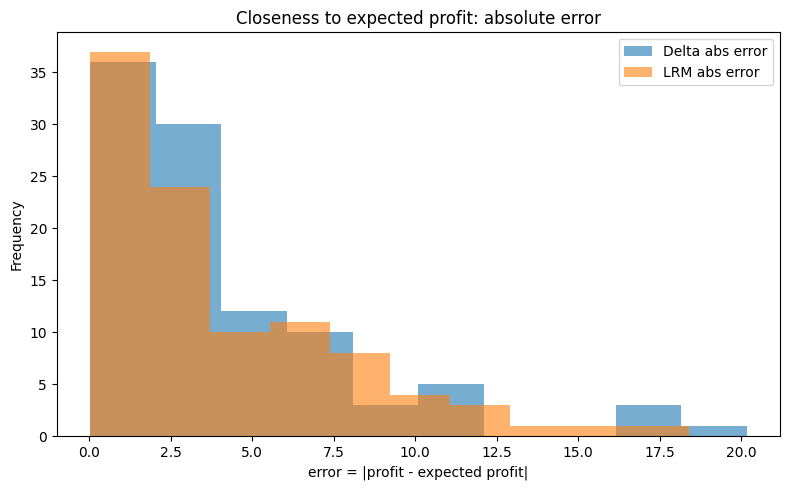

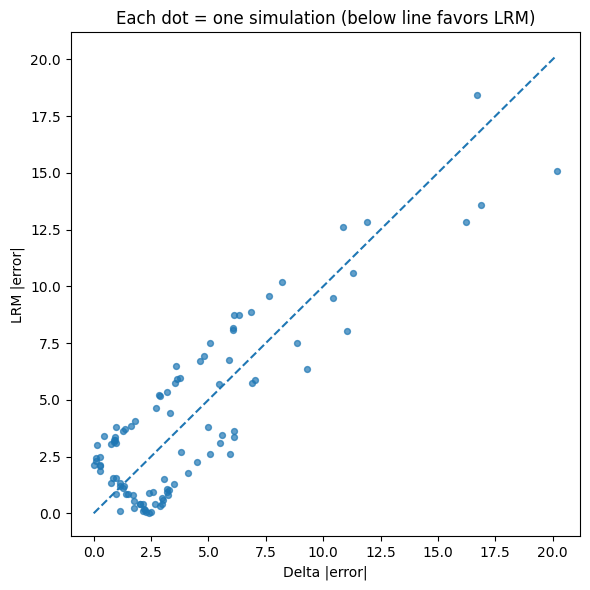

In [179]:

# If you already have df_results from the previous block, just run this:
df = df_results.copy()

# Absolute and squared errors vs expected profit
df["delta_abs_err"] = (df["delta_profit"] - df["expected_profit"]).abs()
df["lrm_abs_err"]   = (df["lrm_profit"]   - df["expected_profit"]).abs()

df["delta_sq_err"] = (df["delta_profit"] - df["expected_profit"])**2
df["lrm_sq_err"]   = (df["lrm_profit"]   - df["expected_profit"])**2

# Mean of absolute error
mae_delta = df["delta_abs_err"].mean()
mae_lrm   = df["lrm_abs_err"].mean()

rmse_delta = np.sqrt(df["delta_sq_err"].mean())
rmse_lrm   = np.sqrt(df["lrm_sq_err"].mean())

win_rate_lrm = (df["lrm_abs_err"] < df["delta_abs_err"]).mean()  # share LRM is closer

summary = pd.DataFrame({
    "MAE":  [mae_delta, mae_lrm],
    "RMSE": [rmse_delta, rmse_lrm],
    "Win rate vs Delta": [np.nan, win_rate_lrm]  # only meaningful for LRM
}, index=["Delta", "LRM"])

display(summary)

# Optional: paired comparison of absolute errors
df["abs_err_diff"] = df["delta_abs_err"] - df["lrm_abs_err"]  # >0 means LRM better
mean_diff = df["abs_err_diff"].mean()
print(f"Mean(abs error Delta - LRM): {mean_diff:.4g}  (>0 favors LRM)")

# --- Visuals ---
# 1) Histograms of absolute error
plt.figure(figsize=(8,5))
bins = max(10, int(np.sqrt(len(df))))
plt.hist(df["delta_abs_err"], bins=bins, alpha=0.6, label="Delta abs error")
plt.hist(df["lrm_abs_err"],   bins=bins, alpha=0.6, label="LRM abs error")
plt.title("Closeness to expected profit: absolute error")
plt.xlabel("error = |profit - expected profit|")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Scatter of absolute errors with 45° line
plt.figure(figsize=(6,6))
plt.scatter(df["delta_abs_err"], df["lrm_abs_err"], s=18, alpha=0.7)
m = max(df["delta_abs_err"].max(), df["lrm_abs_err"].max())
plt.plot([0,m],[0,m], linestyle="--")
plt.xlabel("Delta |error|")
plt.ylabel("LRM |error|")
plt.title("Each dot = one simulation (below line favors LRM)")
plt.tight_layout()
plt.show()


In [ ]:
# Remark (work below need to be polished): If we are allowed to
# hedge with options, then perfect hedging may occur. That is, we can find \phi_t = (\phi_t^1, \phi_t^2) making hedging error zero.
# We illustrate it by using 2-asset (stock S and another European call option G) hedging a call option F

def two_asset_positions(s, tau_F, tau_G,
                        K_target, K_hedge,
                        r, sigma, lam, p, eta1, eta2,
                        price_fun, delta_fun,
                        quad_n=12, u_max=200, N=3000):
    """
    Returns hedge rations (phi_S, phi_G) minimizing Var[ΔF - φ_S ΔS - φ_G ΔG], which has
    closed form solutions given in the work 'Hedging with Options in Models with Jumps' by
    Rama Cont, Peter Tankov, and Ekaterina Voltchkova.
    
    A and b include diffusion (via deltas Fs,Gs) and jump pieces (via Kou expectations).

    ΔF = F(s e^Y, tau_F) - F(s, tau_F)
    ΔG = G(s e^Y, tau_G) - G(s, tau_G)
    """
    # Diffusion block uses deltas at their own maturities
    Fs = delta_fun(s, K_target, tau_F, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)
    Gs = delta_fun(s, K_hedge,  tau_G, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)

    # Prices at (t, s)
    F  = price_fun(s, K_target, tau_F, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)
    G  = price_fun(s, K_hedge,  tau_G, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)

    EJ2 = E_eY_minus1_sq(p, eta1, eta2)
    def dF(y):
        Fy = price_fun(s*np.exp(y), K_target, tau_F, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)
        return Fy - F
    def dG(y):
        Gy = price_fun(s*np.exp(y), K_hedge,  tau_G, r, sigma, lam, p, eta1, eta2, c=None, u_max=u_max, N=N)
        return Gy - G

    E_S_dG  = _kou_expectation(lambda y: (np.exp(y)-1.0) * dG(y), p, eta1, eta2, n=quad_n)
    E_S_dF  = _kou_expectation(lambda y: (np.exp(y)-1.0) * dF(y), p, eta1, eta2, n=quad_n)
    E_dG2   = _kou_expectation(lambda y: dG(y)**2,              p, eta1, eta2, n=quad_n)
    E_dG_dF = _kou_expectation(lambda y: dG(y) * dF(y),         p, eta1, eta2, n=quad_n)

    sig2s2 = (sigma**2) * (s**2)
    A = np.array([
        [ sig2s2 + lam * (s**2) * EJ2,            sig2s2*Gs + lam * s * E_S_dG ],
        [ sig2s2*Gs + lam * s * E_S_dG,           sig2s2*(Gs**2) + lam * E_dG2 ]
    ], dtype=float)
    b = np.array([
        sig2s2 * Fs + lam * s * E_S_dF,
        sig2s2 * Fs * Gs + lam * E_dG_dF
    ], dtype=float)

    try:
        phi = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        phi = np.linalg.lstsq(A + 1e-12*np.eye(2), b, rcond=None)[0]
    return float(phi[0]), float(phi[1])

# --- kou_stock_paths wrapper (handles signature) ---
def _simulate_kou_path(S0, T, steps, sigma, lam, p, eta1, eta2, r, seed):
    try:
        return kou_stock_paths(S0, T, steps, 1, sigma, lam, p, eta1, eta2, r=r, seed=seed)
    except TypeError:
        return kou_stock_paths(S0, T, steps, 1, sigma, lam, p, eta1, eta2, r, seed)

def run_one_sim_two_asset(S0, K_target, K_hedge,
                          T_F, T_G, steps, r,
                          sigma, lam, p, eta1, eta2,
                          price_fun, delta_fun,
                          premium_sigma_shift=0.00, quad_n=12, N_price=2500, seed=None):
    """
    Compare Delta, stock-only LRM, and 2-asset (S + G) with possibly different maturities T_F != T_G.
    """
    times, S_Kou = _simulate_kou_path(S0, T_F, steps, sigma, lam, p, eta1, eta2, r, seed)
    S = S_Kou[:, 0]
    dt = T_F / steps

    # Remaining times for F and G at each step
    taus_F = np.maximum(T_F - times[:-1], 0.0)
    # If hedge maturity is shorter, freeze tau_G at 0 once expired
    taus_G = np.maximum(T_G - np.minimum(times[:-1], T_G), 0.0)

    # Prices of G to compute realized ΔG
    G_prices      = np.array([price_fun(S[i],   K_hedge, taus_G[i], r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price) for i in range(steps)])
    G_prices_next = np.array([price_fun(S[i+1], K_hedge, max(taus_G[i]-dt, 0.0), r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price) for i in range(steps)])

    # Delta positions for target F
    deltas = np.array([
        delta_fun(S[i], K_target, taus_F[i], r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
        for i in range(steps)
    ])

    # Stock-only LRM positions for F
    def phi_LRM_scalar(s, tau):
        F  = price_fun(s, K_target, tau, r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
        Fs = delta_fun(s, K_target, tau, r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
        EJ2 = E_eY_minus1_sq(p, eta1, eta2)
        def integrand(y):
            Fy = price_fun(s*np.exp(y), K_target, tau, r, sigma, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
            return (Fy - F - s*(np.exp(y)-1.0)*Fs) * (np.exp(y)-1.0)
        num = lam * _kou_expectation(integrand, p, eta1, eta2, n=quad_n)
        den = s * (sigma**2 + lam * EJ2)
        return Fs + num/den
    lrm_positions = np.array([phi_LRM_scalar(S[i], taus_F[i]) for i in range(steps)])

    # 2-asset positions (S, G)
    phiS = np.zeros(steps)
    phiG = np.zeros(steps)
    for i in range(steps):
        ps, pg = two_asset_positions(
            s=S[i], tau_F=taus_F[i], tau_G=taus_G[i],
            K_target=K_target, K_hedge=K_hedge,
            r=r, sigma=sigma, lam=lam, p=p, eta1=eta1, eta2=eta2,
            price_fun=price_fun, delta_fun=delta_fun,
            quad_n=quad_n, u_max=200, N=N_price
        )
        phiS[i], phiG[i] = ps, pg

    # Premium for short F (allow a sigma shift if you want pricing P&L)
    premium = price_fun(S0, K_target, T_F, r, sigma + premium_sigma_shift, lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
    fair    = price_fun(S0, K_target, T_F, r, sigma,                lam, p, eta1, eta2, c=None, u_max=200, N=N_price)
    expected_profit = premium - fair

    # Discounted payoff of F
    call_payout_disc = np.maximum(S[-1] - K_target, 0.0) * np.exp(-r*T_F)

    # Discounted gains 
    times_mid = times[1:]  # for discounting
    dS_disc = (S[1:] - S[:-1] * np.exp(r*dt)) * np.exp(-r * times_mid)
    dG_disc = (G_prices_next - G_prices * np.exp(r*dt)) * np.exp(-r * times_mid)

    G_delta = float((dS_disc * deltas).sum())
    G_lrm   = float((dS_disc * lrm_positions).sum())
    G_two   = float((dS_disc * phiS + dG_disc * phiG).sum())

    profit_delta = premium - (call_payout_disc - G_delta)
    profit_lrm   = premium - (call_payout_disc - G_lrm)
    profit_two   = premium - (call_payout_disc - G_two)

    return dict(profit_delta=profit_delta, profit_lrm=profit_lrm, profit_two=profit_two,
                expected_profit=expected_profit, phiS=phiS, phiG=phiG, S=S, times=times)


Delta profit : -5.3856
LRM profit   : -3.4543
2-asset profit: 1.6835
Expected profit (pricing diff): 1.6142


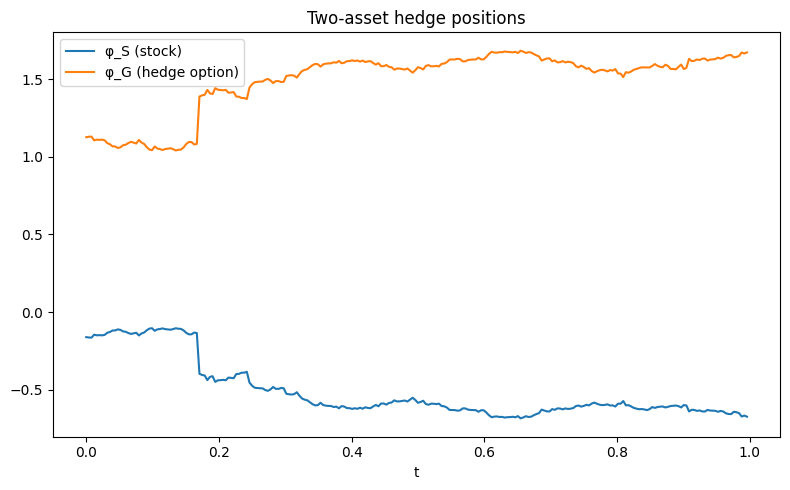

In [182]:
res = run_one_sim_two_asset(
    S0=100.0,
    K_target=100.0,  # the option you are short
    K_hedge=95.0,    # strike for the hedge option may different
    T_F=1.0,         # target maturity
    T_G=1.0,        # hedge maturity (may different)
    steps=252, r=0.03,
    sigma=0.2, lam=3.0, p=0.8, eta1=15, eta2=20,
    price_fun=kou_call_laplace_price, delta_fun=kou_call_delta,
    premium_sigma_shift=0.05, quad_n=12, N_price=2500, seed=None
)
print(f"Delta profit : {res['profit_delta']:.4f}")
print(f"LRM profit   : {res['profit_lrm']:.4f}")
print(f"2-asset profit: {res['profit_two']:.4f}")
print(f"Expected profit (pricing diff): {res['expected_profit']:.4f}")

# quick visual: positions over time
plt.figure(figsize=(8,5))
plt.plot(res["times"][:-1], res["phiS"], label="φ_S (stock)")
plt.plot(res["times"][:-1], res["phiG"], label="φ_G (hedge option)")
plt.title("Two-asset hedge positions")
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()
